In [1]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"

import os
import sys
import random
import warnings
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import ShuffleSplit
import cv2
from scipy import ndimage
import time
import datetime
from image import ImageDataGenerator

seed = 42
random.seed = seed
np.random.seed = seed

# get package versions
def get_version(*vars):
    for var in vars:
        module = __import__(var)    
        print ('%s: %s' %(var,module.__version__))
    
# package version    
get_version('keras','numpy','matplotlib','cv2','theano')


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 20.0% of memory, cuDNN 5110)


keras: 2.1.3
numpy: 1.13.3
matplotlib: 2.1.0
cv2: 2.4.13
theano: 0.9.0.dev-425cb8effc7958e8ca376b023d8344b7620a9622


## Settings

In [2]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_PATH = '../data/stage1_train/'
TEST_PATH = '../data/stage1_test/'

# normalization type
norm_type='zeroMeanUnitStd'
norm_type=None

netinfo='trainTest4'
initialLearningRate=3e-4


# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

## Utilities

In [3]:
# random data generator
datagen = ImageDataGenerator(featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.01,
        zoom_range=0.01,
        channel_shift_range=0.0,
        fill_mode='constant',
        cval=0.0,
        horizontal_flip=True,
        vertical_flip=True,)
        #data_format="channels_first") 
    
# calcualte dice
def calc_dice(X,Y,d=0):
    N=X.shape[d]    
    # intialize dice vector
    dice=np.zeros([N,1])

    for k in range(N):
        x=X[k,0] >.5 # convert to logical
        y =Y[k,0]>.5 # convert to logical

        # number of ones for intersection and union
        intersectXY=np.sum((x&y==1))
        unionXY=np.sum(x)+np.sum(y)

        if unionXY!=0:
            dice[k]=2* intersectXY/(unionXY*1.0)
            #print 'dice is: %0.2f' %dice[k]
        else:
            dice[k]=1
            #print 'dice is: %0.2f' % dice[k]
        #print 'processing %d, dice= %0.2f' %(k,dice[k])
    return np.mean(dice),dice

def preprocess(X,xnormType=None):
    if xnormType=='minus1plus1':
        X=X.astype('float32')
        X/=np.max(X)
        X-=0.5
        X=X*2
    elif xnormType=='zeroMeanUnitStd':
        X=X.astype('float32')
        # we do this per channel
        for c in range(X.shape[1]):
            X[:,c]-=np.mean(X[:,c])
            stdXc=np.std(X[:,c])
            if stdXc>0.0:
                X[:,c]/=stdXc
    elif xnormType is None:
        pass
    else:
        raise IOError('normalization type not found!')
    return X

def array_stats(X):
    X=np.asarray(X)
    print ('array shape: ',X.shape, X.dtype)
    #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
    print ('min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X)))

def resizeY(Y,origHW):
    # Y shape is N*1*H*W
    N=Y.shape[0] 
    Yr=[]
    for k in range(N):
        temp=resize(Y[k,0], (origHW[k,0], origHW[k,1]), mode='constant', preserve_range=True)
        
        #Yr.append(np.array(temp,'uint8'))
        Yr.append(temp)
    return Yr

def resizeX(X,origHW):
    # Y shape is N*1*H*W
    N=X.shape[0] 
    Xr=[]
    for k in range(N):
        Xk=X[k]
        Xk=np.transpose(Xk,(1,2,0))
        temp=resize(Xk, (origHW[k,0], origHW[k,1]), mode='constant', preserve_range=True)
        temp=np.transpose(temp,(2,0,1))
        Xr.append(np.array(temp,'uint8'))
    return Xr

def loadData0(ids,path2data):
    print('loading '+path2data)
    # Get and resize train images and masks
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    origHW=np.zeros((len(ids),3),dtype='uint16') # store original dimension for later use
    
    print('Getting and resizing images and masks ... ')
    #sys.stdout.flush()
    for n, id_ in enumerate(ids):
        path = path2data + id_   
        #print(path)
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        h,w,c=img.shape
        origHW[n]=img.shape
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        try:
            for mask_file in next(os.walk(path + '/masks/'))[2]:
                mask_ = imread(path + '/masks/' + mask_file)
                mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                              preserve_range=True), axis=-1)
                mask = np.maximum(mask, mask_)
            Y[n] = mask
        except:
            Y=[]
    if len(Y):
        Y=np.transpose(Y,(0,3,1,2))
    return np.transpose(X,(0,3,1,2)),Y,origHW


def loadData(path2h5,data_type='train'):
    if not os.path.exists(path2h5):
        X_train,Y_train,HW_train=loadData0(train_ids,TRAIN_PATH)
        h5file=h5py.File(path2h5,'w-')
        h5file['X_train']=X_train
        h5file['Y_train']=Y_train
        h5file['HW_train']=HW_train
            
        X_test,Y_test,HW_test=loadData0(test_ids,TEST_PATH)
        h5file['X_test']=X_test
        h5file['Y_test']=Y_test
        h5file['HW_test']=HW_test
    else:
        print('loading '+ path2h5)
        h5file=h5py.File(path2h5,'r')
        X_train=h5file['X_train']
        Y_train=h5file['Y_train']
        HW_train=h5file['HW_train']
        
        X_test=h5file['X_test']
        Y_test=h5file['Y_test']
        HW_test=h5file['HW_test']
        
    if data_type=="train":
        return X_train,Y_train,np.array(HW_train,'uint16')
    elif data_type=="leader":
        return X_test,Y_test,np.array(HW_test,'uint16')


def iterate_minibatches(inputs1 , targets,  batchsize, shuffle=True, augment=True):
    assert len(inputs1) == len(targets)
    if augment==True:
        if shuffle:
            indices = np.arange(len(inputs1))
            np.random.shuffle(indices)
        for start_idx in range(0, len(inputs1) - batchsize + 1, batchsize):
            if shuffle:
                excerpt = indices[start_idx:start_idx + batchsize]
            else:
                excerpt = slice(start_idx, start_idx + batchsize)
            x = inputs1[excerpt]
            y = targets[excerpt] 
            for  xxt,yyt in datagen.flow(x, y , batch_size=x.shape[0]):
                x = xxt.astype(np.float32) 
                y = yyt 
                break
    else:
        x=inputs1
        y=targets

    #yield np.array(x,np.uint8), np.array(y, dtype=np.uint8)         
    return np.array(x,np.uint8), np.array(y, dtype=np.uint8)     
    
    
# train test model
def train_test_model(X_train,y_train,X_test,y_test,params_train):
    foldnm=params_train['foldnm']  
    pre_train=params_train['pre_train'] 
    batch_size=params_train['batch_size'] 
    augmentation=params_train['augmentation'] 
    path2weights=params_train['path2weights'] 
    path2model=params_train['path2model'] 
    norm_type=params_train['norm_type'] 
    
    print('batch_size: %s, Augmentation: %s' %(batch_size,augmentation))
    
    print 'fold %s training in progress ...' %foldnm
    # load last weights
    if pre_train== True:
        if  os.path.exists(path2weights):
            model.load_weights(path2weights)
            print 'previous weights loaded!'
        else:
            raise IOError('weights does not exist!!!')
    else:
        if  os.path.exists(path2weights):
            model.load_weights(path2weights)
            print (path2weights)
            print ('previous weights loaded!')
            train_status='previous weights'
            return train_status
    
    # path to csv file to save scores
    path2scorescsv = weightfolder+'/scores.csv'
    first_row = 'train,test'
    with open(path2scorescsv, 'w+') as f:
        f.write(first_row + '\n')
           
    # Fit the model
    start_time=time.time()
    scores_test=[]
    scores_train=[]
    if params_train['loss']=='dice': 
        best_score = 0
        previous_score = 0
    else:
        best_score = 1e6
        previous_score = 1e6
    patience = 0
    
    # convert class vectors to binary class matrices
    
    
    for epoch in range(params_train['nbepoch']):
    
        print ('epoch: %s,  Current Learning Rate: %.1e' %(epoch,model.optimizer.lr.get_value()))
        #seed = np.random.randint(0, 999999)
    
        if augmentation:
            X_batch,Y_batch=iterate_minibatches(X_train,y_train,X_train.shape[0],shuffle=False,augment=True)  
            Y_batch=Y_batch[:,0][:,np.newaxis]
            #model.fit_generator(train_generator, steps_per_epoch=len(xtr)/batch_size, epochs=1,verbose=0)            
            hist=model.fit(preprocess(X_batch,norm_type), Y_batch, batch_size=batch_size,epochs=1, verbose=0)
        else:
            hist=model.fit(preprocess(X_train,norm_type), y_train, batch_size=batch_size,epochs=1, verbose=0)
            
        # evaluate on test and train data
        score_test=model.evaluate(preprocess(X_test,norm_type),y_test,verbose=0)
        score_train=np.mean(hist.history['loss'])
       
        print ('score_train: %s, score_test: %s' %(score_train,score_test))
        scores_test=np.append(scores_test,score_test)
        scores_train=np.append(scores_train,score_train)    

        # check for improvement    
        if (score_test<=best_score):
            print ("!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!") 
            best_score = score_test
            patience = 0
            model.save_weights(path2weights)  
            model.save(path2model)
            
        # learning rate schedule
        if score_test>previous_score:
            #print "Incrementing Patience."
            patience += 1

        # learning rate schedule                
        if patience == params_train['max_patience']:
            params_train['learning_rate'] = params_train['learning_rate']/2
            print ("Upating Current Learning Rate to: ", params_train['learning_rate'])
            model.optimizer.lr.set_value(params_train['learning_rate'])
            print ("Loading the best weights again. best_score: ",best_score)
            model.load_weights(path2weights)
            patience = 0
        
        # save current test score
        previous_score = score_test    
        
        # store scores into csv file
        with open(path2scorescsv, 'a') as f:
            string = str([score_train,score_test])
            f.write(string + '\n')
           
    
    print ('model was trained!')
    elapsed_time=(time.time()-start_time)/60
    print ('elapsed time: %d  mins' %elapsed_time)      

    # train test progress plots
    plt.figure(figsize=(10,10))
    plt.plot(scores_test)
    plt.plot(scores_train)
    plt.title('train-validation progress',fontsize=20)
    plt.legend(('test','train'),fontsize=20)
    plt.xlabel('epochs',fontsize=20)
    plt.ylabel('loss',fontsize=20)
    plt.grid(True)
    plt.savefig(weightfolder+'/train_val_progress.png')
    plt.show()
    
    print 'training completed!'
    train_status='completed!'
    return train_status    

def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img))


def image_with_mask(img, mask,color=(0,255,0)):
    mask=np.asarray(mask,dtype='uint8') 
    
    if len(img.shape)==2:
        img_color = grays_to_RGB(img)
    else:
        img_color =img

    mask2=mask[:,:,0]
    for c1 in range(mask.shape[2]):
        mask2=np.logical_or(mask2,mask[:,:,c1])
    mask2=np.array(255*mask2,'uint8')
        
    mask_edges = cv2.Canny(mask2, 100, 200) > 0
    #plt.imshow(mask_edges)
    maximg=np.max(img)
    img_color[mask_edges, 0] = maximg*color[0]  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = maximg*color[1]
    img_color[mask_edges, 2] = maximg*color[2]
    return img_color

def disp_img_2masks(img,mask1=None,mask2=None,r=1,c=1,d=0,indices=None):
    if mask1 is None:
        mask1=np.zeros(img.shape,dtype='uint8')
    else:
        mask1=np.array(mask1,dtype='uint8')
    if mask2 is None:
        mask2=np.zeros(img.shape,dtype='uint8')
    else:        
        mask2=np.array(mask2,dtype='uint8')    
        
    N=r*c    
    if d==2:
        # convert to N*C*H*W
        img=np.transpose(img,(2,0,1))
        img=np.expand_dims(img,axis=1)
        
        mask1=np.transpose(mask1,(2,0,1))
        mask1=np.expand_dims(mask1,axis=1)

        mask2=np.transpose(mask2,(2,0,1))
        mask2=np.expand_dims(mask2,axis=1)
        
    if indices is None:    
        indices=np.random.randint(img.shape[0],size=N)
    
    # collect images and masks
    I1=[np.transpose(img[i],(1,2,0)) for i in indices]
    M1=[np.transpose(mask1[i],(1,2,0)) for i in indices]
    M2=[np.transpose(mask2[i],(1,2,0)) for i in indices]
    
    C1=(0,255,0)
    C2=(255,0,0)
    for k in range(N):    
        imgmask=image_with_mask(I1[k],M1[k],C1)
        imgmask=image_with_mask(imgmask,M2[k],C2)
        plt.subplot(r,c,k+1)
        plt.imshow(imgmask)
        plt.title(indices[k])
    plt.show()            
    


## loading data

loading ../data/trainTestH256W256.hdf5
('array shape: ', (670, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 43.4, std:68.5
('array shape: ', (670, 1, 256, 256), dtype('bool'))
min: False, max: True, avg: 0.151, std:0.358
('array shape: ', (670, 3), dtype('uint16'))
min: 3, max: 1388, avg: 2.38e+02, std:2.22e+02


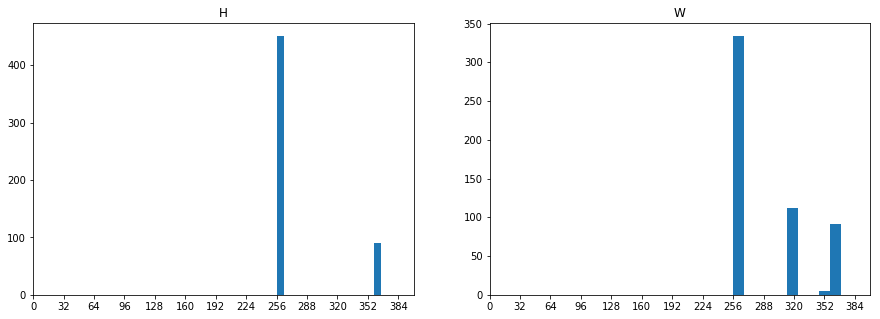

In [25]:
path2h5='../data/trainTestH'+str(IMG_HEIGHT)+'W'+str(IMG_WIDTH)+'.hdf5'
X,Y,HW_train=loadData(path2h5,'train')
array_stats(X)
array_stats(Y)
array_stats(HW_train)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(HW_train[:,0],100)
plt.xlim([0,400])
plt.xticks(range(0,400,32))
plt.title('H')
plt.subplot(1,2,2)
plt.hist(HW_train[:,1],100)
plt.xlim([0,400])
plt.xticks(range(0,400,32))
plt.title('W')
plt.show()

## Display data

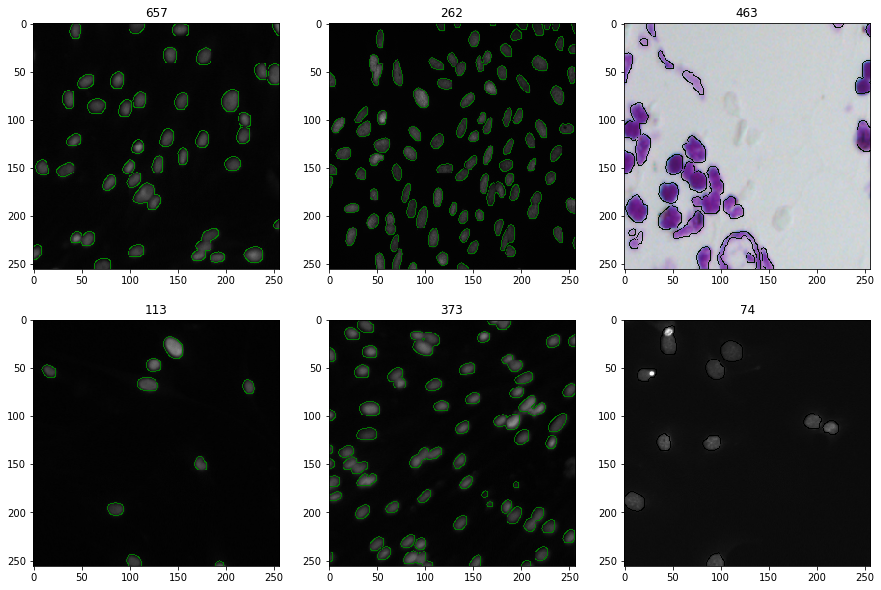

In [5]:
plt.figure(figsize=(15,10))
disp_img_2masks(img=X,mask1=Y,r=2,c=3)

## AI model

In [6]:
from keras.layers import Input, merge, Convolution2D, Deconvolution2D, AtrousConvolution2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Dense
from keras.layers.core import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.utils import layer_utils
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose
from keras.layers import Concatenate
from keras.layers import AtrousConv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Dense
from keras.layers.core import Activation
from keras.layers import Activation,Reshape,Permute
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.utils import layer_utils
from keras.layers.normalization import BatchNormalization

# model
def model_skip(params):

    h=params['h']
    w=params['w']
    z=params['z']
    lr=params['learning_rate']
    loss=params['loss']
    C=params['initial_channels']
    nb_output=params['num_labels']
    dropout_rate=params['dropout_rate']
    data_format='channels_first'
    batchNorm=params['batchNorm']
    w2reg=params['w2reg']
    initStride=params['initStride']
    reshape4softmax=params['reshape4softmax']
    
    
    inputs = Input((z,h, w))
    conv1 = Conv2D(C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg,strides=initStride)(inputs)
    if batchNorm:
        conv1=BatchNormalization(axis=1)(conv1)
    conv1=Activation('relu')(conv1)        
    
    conv1 = Conv2D(C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(conv1)
    if batchNorm:
        conv1=BatchNormalization(axis=1)(conv1)
    conv1=Activation('relu')(conv1)        

    pool1 = MaxPooling2D(pool_size=(2, 2),data_format=data_format)(conv1)

    conv2 = Conv2D(2*C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(pool1)
    if batchNorm:
        conv2=BatchNormalization(axis=1)(conv2)
    conv2=Activation('relu')(conv2)        
    
    conv2 = Conv2D(2*C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(conv2)
    if batchNorm:
        conv2=BatchNormalization(axis=1)(conv2)
    conv2=Activation('relu')(conv2)        
    
    pool2 = MaxPooling2D(pool_size=(2, 2),data_format=data_format)(conv2)

    conv3 = Conv2D(4*C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(pool2)
    if batchNorm:
        conv3=BatchNormalization(axis=1)(conv3)
    conv3=Activation('relu')(conv3)        
    
    conv3 = Conv2D(4*C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(conv3)
    if batchNorm:
        conv3=BatchNormalization(axis=1)(conv3)
    conv3=Activation('relu')(conv3)        
    
    pool3 = MaxPooling2D(pool_size=(2, 2),data_format=data_format)(conv3)

    conv4 = Conv2D(8*C, 3,  padding='same',data_format=data_format,kernel_regularizer=w2reg)(pool3)
    if batchNorm:
        conv4=BatchNormalization(axis=1)(conv4)
    conv4=Activation('relu')(conv4)        
    
    conv4 = Conv2D(8*C, 3,  padding='same',data_format=data_format,kernel_regularizer=w2reg)(conv4)
    if batchNorm:
        conv4=BatchNormalization(axis=1)(conv4)
    conv4=Activation('relu')(conv4)        
    
    pool4 = MaxPooling2D(pool_size=(2, 2),data_format=data_format)(conv4)

    conv5 = Conv2D(16*C,  3,  padding='same',data_format=data_format,kernel_regularizer=w2reg)(pool4)
    if batchNorm:
        conv5=BatchNormalization(axis=1)(conv5)
    conv5=Activation('relu')(conv5)        
    
    conv5 = Conv2D(16*C, 3,  padding='same',data_format=data_format,kernel_regularizer=w2reg)(conv5)
    if batchNorm:
        conv5=BatchNormalization(axis=1)(conv5)
    conv5=Activation('relu')(conv5)        
    
    conv5 =Dropout(dropout_rate)(conv5)
    #pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    
    up7=UpSampling2D(size=(2, 2),data_format=data_format)(conv5)
    concat = Concatenate(axis=1)
    up7 = concat([up7, conv4])
    conv7 = Conv2D(8*C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(up7)
    if batchNorm:
        conv7=BatchNormalization(axis=1)(conv7)
    conv7=Activation('relu')(conv7)        
    
    up8 = concat([UpSampling2D(size=(2, 2),data_format=data_format)(conv7), conv3])
    conv8 = Conv2D(4*C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(up8)
    if batchNorm:
        conv8=BatchNormalization(axis=1)(conv8)
    conv8=Activation('relu')(conv8)        
    
    up9 = concat([UpSampling2D(size=(2, 2),data_format=data_format)(conv8), conv2])
    conv9 = Conv2D(2*C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(up9)
    if batchNorm:
        conv9=BatchNormalization(axis=1)(conv9)
    conv9=Activation('relu')(conv9)        
    

    up10 = concat([UpSampling2D(size=(2, 2),data_format=data_format)(conv9), conv1])
    conv10 = Conv2D(C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(up10)
    if batchNorm:
        conv10=BatchNormalization(axis=1)(conv10)
    conv10=Activation('relu')(conv10)        
    
    conv10 = UpSampling2D(size=(initStride, initStride),data_format=data_format)(conv10)
    if batchNorm:
        conv10=BatchNormalization(axis=1)(conv10)
    conv10=Activation('relu')(conv10)        
    
    conv10 = Conv2D(C, 3, padding='same',data_format=data_format,kernel_regularizer=w2reg)(conv10)
    if batchNorm:
        conv10=BatchNormalization(axis=1)(conv10)
    conv10=Activation('relu')(conv10)        
    
    conv10 = Conv2D(nb_output, 1, data_format=data_format,kernel_regularizer=w2reg)(conv10)

    if reshape4softmax:
        # reshape for softmax
        output=Reshape((nb_output,h*w)) (conv10)
        # permute for softmax
        output=Permute((2,1))(output)
        # softmax
        output=Activation('softmax')(output)
    else:        
        output=Activation('sigmoid')(conv10)
    
    model = Model(inputs=inputs, outputs=output)

    if loss=='dice':
        model.compile(optimizer=Adam(lr), loss=dice_coef_loss, metrics=[dice_coef])
    else:
        #model.compile(loss='binary_crossentropy', optimizer=Adam(lr))
        model.compile(loss=loss, optimizer=Adam(lr))
    
    return model

In [7]:
n,z,h,w=X.shape
params_train={
    'h': h,
    'w': w,
    'z':z,
    'learning_rate': initialLearningRate,
    'optimizer': 'Adam',
    #'loss': 'categorical_crossentropy',
    'loss': 'binary_crossentropy',
    'nbepoch': 300 ,
    'num_labels': 1,
    'initial_channels':16,
    'dropout_rate': 0.5,
    'max_patience': 30,
    'experiment': None,
    'pre_train': False,
    'elastic_arg': None,
    'trainaug_params': None,
    'batch_size': 10,
    'weightfolder': None,
    'w2reg': None, #regularizers.l2(1e-4),    
    'batchNorm': False,
    'initStride': 2,
    'norm_type': norm_type,
    'augmentation': True,
    'reshape4softmax': False,
    }
    
model = model_skip(params_train)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 256, 256)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 128, 128) 448         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 128, 128) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 128, 128) 2320        activation_1[0][0]               
__________________________________________________________________________________________________
activation

conv2d_14 (Conv2D)              (None, 16, 128, 128) 6928        concatenate_1[3][0]              
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 16, 128, 128) 0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_5 (UpSampling2D)  (None, 16, 256, 256) 0           activation_14[0][0]              
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 16, 256, 256) 0           up_sampling2d_5[0][0]            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 256, 256) 2320        activation_15[0][0]              
__________________________________________________________________________________________________
activation

wait ...
('array shape: ', (603, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 43.6, std:69.1
('array shape: ', (603, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.151, std:0.358
('array shape: ', (67, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 41.1, std:63.1
('array shape: ', (67, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.15, std:0.357
------------------------------
('experiment:', 'trainTest4_hw_256by256_initfilts_16')
weights folder created
batch_size: 10, Augmentation: True
fold 1 training in progress ...
epoch: 0,  Current Learning Rate: 3.0e-04
score_train: 0.506087604249, score_test: 0.288566948095
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 1,  Current Learning Rate: 3.0e-04
score_train: 0.209456172983, score_test: 0.175215406538
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 2,  Current Learning Rate: 3.0e-04
score_train: 0.159542018921, score_test: 0.150279748462
!!!!!!!!!!

score_train: 0.0604834941341, score_test: 0.0683593343276
epoch: 58,  Current Learning Rate: 3.0e-04
score_train: 0.0602317235771, score_test: 0.0691336524019
epoch: 59,  Current Learning Rate: 3.0e-04
score_train: 0.0588951915206, score_test: 0.0673785181021
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 60,  Current Learning Rate: 3.0e-04
score_train: 0.0583174997264, score_test: 0.0691283735544
epoch: 61,  Current Learning Rate: 3.0e-04
score_train: 0.0583976702101, score_test: 0.0696012849516
epoch: 62,  Current Learning Rate: 3.0e-04
score_train: 0.0578120457592, score_test: 0.0693133190107
epoch: 63,  Current Learning Rate: 3.0e-04
score_train: 0.0588730410989, score_test: 0.0654400976569
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 64,  Current Learning Rate: 3.0e-04
score_train: 0.0575840669942, score_test: 0.0664067994525
epoch: 65,  Current Learning Rate: 3.0e-04
score_train: 0.0590414151759, score_test: 0.06

score_train: 0.0510339447997, score_test: 0.0682940810029
epoch: 136,  Current Learning Rate: 3.0e-04
score_train: 0.0515996046537, score_test: 0.0709265652877
epoch: 137,  Current Learning Rate: 3.0e-04
score_train: 0.0515082770616, score_test: 0.0653907972763
epoch: 138,  Current Learning Rate: 3.0e-04
score_train: 0.0509760648408, score_test: 0.0649975095667
epoch: 139,  Current Learning Rate: 3.0e-04
score_train: 0.0513666853753, score_test: 0.0668308104375
epoch: 140,  Current Learning Rate: 3.0e-04
score_train: 0.0501128092198, score_test: 0.0669651777108
epoch: 141,  Current Learning Rate: 3.0e-04
score_train: 0.050211147694, score_test: 0.0677146828497
epoch: 142,  Current Learning Rate: 3.0e-04
score_train: 0.0505391600824, score_test: 0.0710935508693
epoch: 143,  Current Learning Rate: 3.0e-04
score_train: 0.0513586215366, score_test: 0.0656350940577
epoch: 144,  Current Learning Rate: 3.0e-04
score_train: 0.0509982815825, score_test: 0.0646753496032
epoch: 145,  Current Lear

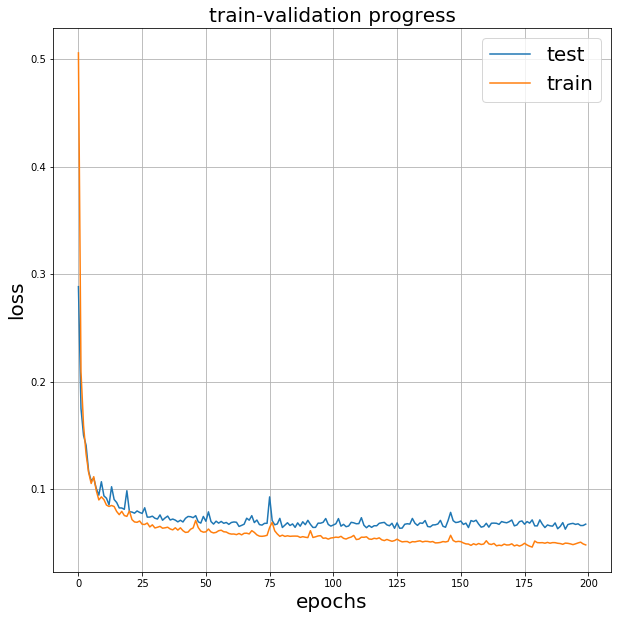

training completed!
weights loaded!
score_test: 0.06288
average dice: 0.92
------------------------------
('array shape: ', (603, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 43.6, std:68.5
('array shape: ', (603, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.15, std:0.357
('array shape: ', (67, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 41.6, std:68.6
('array shape: ', (67, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.164, std:0.371
------------------------------
('experiment:', 'trainTest4_hw_256by256_initfilts_16')
weights folder created
batch_size: 10, Augmentation: True
fold 2 training in progress ...
epoch: 0,  Current Learning Rate: 3.0e-04
score_train: 0.500456383671, score_test: 0.254503828376
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 1,  Current Learning Rate: 3.0e-04
score_train: 0.201226000713, score_test: 0.26082098484
epoch: 2,  Current Learning Rate: 3.0e-04
score_train: 0.158610607607, score_test: 0.

score_train: 0.0590618871968, score_test: 0.0659369107947
epoch: 59,  Current Learning Rate: 3.0e-04
score_train: 0.0578164116944, score_test: 0.0662221973067
epoch: 60,  Current Learning Rate: 3.0e-04
score_train: 0.0598990829757, score_test: 0.0649209078123
epoch: 61,  Current Learning Rate: 3.0e-04
score_train: 0.0578150169099, score_test: 0.0660893794761
epoch: 62,  Current Learning Rate: 3.0e-04
score_train: 0.0589084738609, score_test: 0.0657314458
epoch: 63,  Current Learning Rate: 3.0e-04
score_train: 0.0588174658097, score_test: 0.0689260110037
epoch: 64,  Current Learning Rate: 3.0e-04
score_train: 0.0587847954401, score_test: 0.0648163018832
epoch: 65,  Current Learning Rate: 3.0e-04
score_train: 0.0591838879026, score_test: 0.0631617111946
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 66,  Current Learning Rate: 3.0e-04
score_train: 0.0579254458817, score_test: 0.0657306825047
epoch: 67,  Current Learning Rate: 3.0e-04
score_train: 0.058007

score_train: 0.0515065008209, score_test: 0.0627165476778
epoch: 138,  Current Learning Rate: 3.0e-04
score_train: 0.0502264288256, score_test: 0.0650942265543
epoch: 139,  Current Learning Rate: 3.0e-04
score_train: 0.0520411178309, score_test: 0.0676829639211
epoch: 140,  Current Learning Rate: 3.0e-04
score_train: 0.0580251012214, score_test: 0.0758980081153
epoch: 141,  Current Learning Rate: 3.0e-04
score_train: 0.0551908058956, score_test: 0.0663012266159
epoch: 142,  Current Learning Rate: 3.0e-04
score_train: 0.0545584264074, score_test: 0.0613460625286
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 143,  Current Learning Rate: 3.0e-04
score_train: 0.0507039749102, score_test: 0.0633822245829
epoch: 144,  Current Learning Rate: 3.0e-04
score_train: 0.0504130737155, score_test: 0.0632463117589
epoch: 145,  Current Learning Rate: 3.0e-04
score_train: 0.0512346285295, score_test: 0.0638735027456
epoch: 146,  Current Learning Rate: 3.0e-04
score_tra

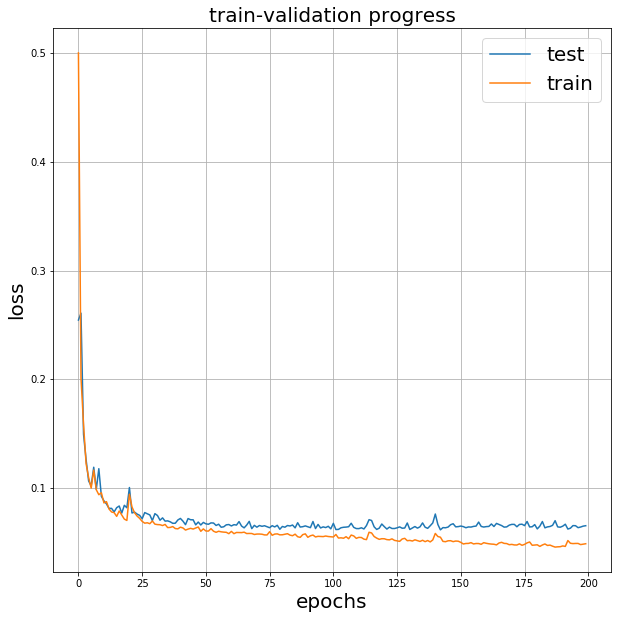

training completed!
weights loaded!
score_test: 0.06135
average dice: 0.91
------------------------------
('array shape: ', (603, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 43.1, std:68.2
('array shape: ', (603, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.151, std:0.358
('array shape: ', (67, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 45.7, std:70.7
('array shape: ', (67, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.15, std:0.357
------------------------------
('experiment:', 'trainTest4_hw_256by256_initfilts_16')
weights folder created
batch_size: 10, Augmentation: True
fold 3 training in progress ...
epoch: 0,  Current Learning Rate: 3.0e-04
score_train: 0.319857604394, score_test: 0.19703413535
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 1,  Current Learning Rate: 3.0e-04
score_train: 0.238950788499, score_test: 0.212703112457
epoch: 2,  Current Learning Rate: 3.0e-04
score_train: 0.151961367176, score_test: 0.

score_train: 0.0597779409493, score_test: 0.0616358911146
epoch: 59,  Current Learning Rate: 3.0e-04
score_train: 0.060521525215, score_test: 0.0703191613195
epoch: 60,  Current Learning Rate: 3.0e-04
score_train: 0.060732466683, score_test: 0.061928045505
epoch: 61,  Current Learning Rate: 3.0e-04
score_train: 0.0592054989819, score_test: 0.0608697120489
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 62,  Current Learning Rate: 3.0e-04
score_train: 0.0576747763735, score_test: 0.061688003589
epoch: 63,  Current Learning Rate: 3.0e-04
score_train: 0.0580614431333, score_test: 0.0616653288311
epoch: 64,  Current Learning Rate: 3.0e-04
score_train: 0.0583489997309, score_test: 0.0609796543453
epoch: 65,  Current Learning Rate: 3.0e-04
score_train: 0.0595971540815, score_test: 0.0610534426715
epoch: 66,  Current Learning Rate: 3.0e-04
score_train: 0.0564908850351, score_test: 0.0622601238316
epoch: 67,  Current Learning Rate: 3.0e-04
score_train: 0.0570509

score_train: 0.0521117243391, score_test: 0.0579090894881
epoch: 133,  Current Learning Rate: 3.0e-04
score_train: 0.0507993024046, score_test: 0.0587544156822
epoch: 134,  Current Learning Rate: 3.0e-04
score_train: 0.052321896896, score_test: 0.0579183859222
epoch: 135,  Current Learning Rate: 3.0e-04
score_train: 0.0526173273982, score_test: 0.0585486199707
epoch: 136,  Current Learning Rate: 3.0e-04
score_train: 0.0509166331347, score_test: 0.0569051886116
epoch: 137,  Current Learning Rate: 3.0e-04
score_train: 0.0507723367703, score_test: 0.0576969203331
epoch: 138,  Current Learning Rate: 3.0e-04
score_train: 0.0531297360128, score_test: 0.0590203267647
epoch: 139,  Current Learning Rate: 3.0e-04
score_train: 0.0514352768968, score_test: 0.0585025989298
epoch: 140,  Current Learning Rate: 3.0e-04
score_train: 0.0508555087506, score_test: 0.059506022274
epoch: 141,  Current Learning Rate: 3.0e-04
score_train: 0.0516404654046, score_test: 0.0567381581041
epoch: 142,  Current Learn

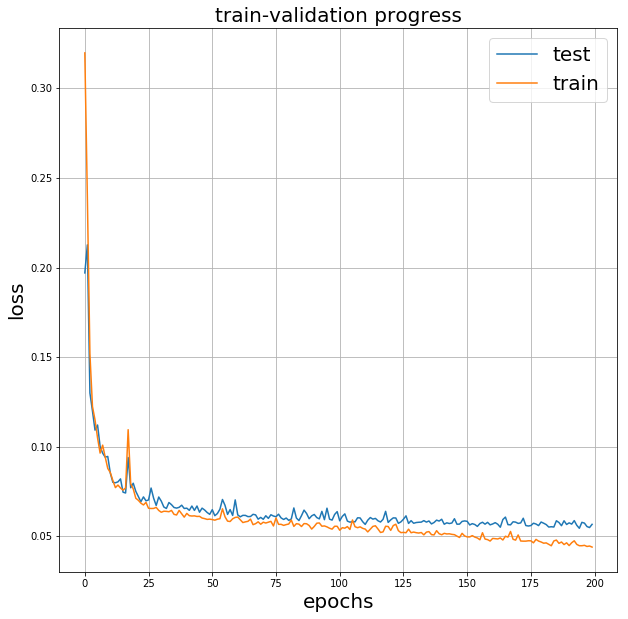

training completed!
weights loaded!
score_test: 0.05447
average dice: 0.91
------------------------------
('array shape: ', (603, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 43.9, std:68.7
('array shape: ', (603, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.152, std:0.359
('array shape: ', (67, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 38.8, std:66.9
('array shape: ', (67, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.142, std:0.349
------------------------------
('experiment:', 'trainTest4_hw_256by256_initfilts_16')
weights folder created
batch_size: 10, Augmentation: True
fold 4 training in progress ...
epoch: 0,  Current Learning Rate: 3.0e-04
score_train: 0.533809472623, score_test: 0.203444319874
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 1,  Current Learning Rate: 3.0e-04
score_train: 0.173478702025, score_test: 0.236751215671
epoch: 2,  Current Learning Rate: 3.0e-04
score_train: 0.145277635103, score_test: 

score_train: 0.0603923919436, score_test: 0.0559306945374
epoch: 62,  Current Learning Rate: 3.0e-04
score_train: 0.0593531776288, score_test: 0.0566949030357
epoch: 63,  Current Learning Rate: 3.0e-04
score_train: 0.0617887846458, score_test: 0.0543717999957
epoch: 64,  Current Learning Rate: 3.0e-04
score_train: 0.0597144871901, score_test: 0.0587113895523
epoch: 65,  Current Learning Rate: 3.0e-04
score_train: 0.0600938469505, score_test: 0.0549536116088
epoch: 66,  Current Learning Rate: 3.0e-04
score_train: 0.058870957043, score_test: 0.0534872047937
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 67,  Current Learning Rate: 3.0e-04
score_train: 0.0638506640163, score_test: 0.0529181018694
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 68,  Current Learning Rate: 3.0e-04
score_train: 0.0588368034704, score_test: 0.0536633160577
epoch: 69,  Current Learning Rate: 3.0e-04
score_train: 0.0623122989995, score_test: 0.057

score_train: 0.0499251968047, score_test: 0.0523714754564
epoch: 139,  Current Learning Rate: 3.0e-04
score_train: 0.048593467086, score_test: 0.0561858328866
epoch: 140,  Current Learning Rate: 3.0e-04
score_train: 0.0497700980313, score_test: 0.0556222587379
epoch: 141,  Current Learning Rate: 3.0e-04
score_train: 0.048545185007, score_test: 0.0510445586336
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 142,  Current Learning Rate: 3.0e-04
score_train: 0.0496422785147, score_test: 0.0502790879847
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 143,  Current Learning Rate: 3.0e-04
score_train: 0.0489684321375, score_test: 0.0514437018046
epoch: 144,  Current Learning Rate: 3.0e-04
score_train: 0.0504596231715, score_test: 0.0522973194941
epoch: 145,  Current Learning Rate: 3.0e-04
score_train: 0.0508621593947, score_test: 0.0553946953211
epoch: 146,  Current Learning Rate: 3.0e-04
score_train: 0.0492397382868, score_test

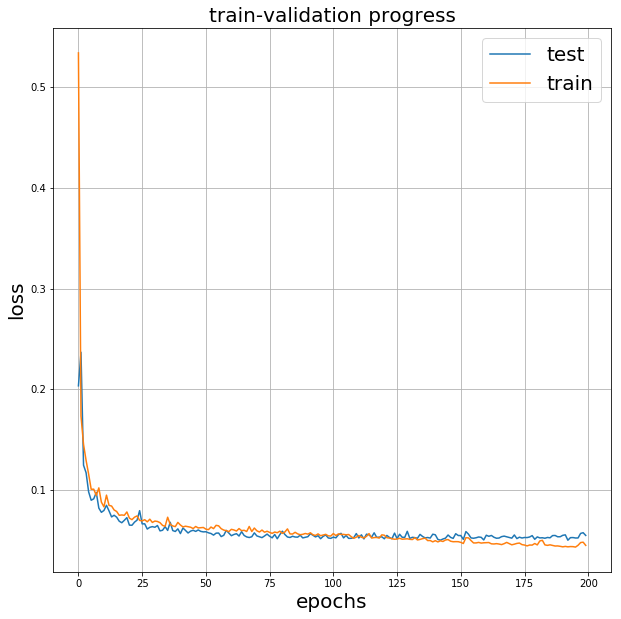

training completed!
weights loaded!
score_test: 0.05024
average dice: 0.91
------------------------------
('array shape: ', (603, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 44.1, std:69.2
('array shape: ', (603, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.153, std:0.36
('array shape: ', (67, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 37.0, std:61.3
('array shape: ', (67, 1, 256, 256), dtype('uint8'))
min: 0, max: 1, avg: 0.133, std:0.34
------------------------------
('experiment:', 'trainTest4_hw_256by256_initfilts_16')
weights folder created
batch_size: 10, Augmentation: True
fold 5 training in progress ...
epoch: 0,  Current Learning Rate: 3.0e-04
score_train: 0.330532361878, score_test: 0.181127297789
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 1,  Current Learning Rate: 3.0e-04
score_train: 0.171798757356, score_test: 0.161608850778
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 2,  C

score_train: 0.0580515740547, score_test: 0.0607664043834
epoch: 59,  Current Learning Rate: 3.0e-04
score_train: 0.0586501429379, score_test: 0.0584652027977
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 60,  Current Learning Rate: 3.0e-04
score_train: 0.057199058248, score_test: 0.0582316665729
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 61,  Current Learning Rate: 3.0e-04
score_train: 0.0588735752673, score_test: 0.0608288519251
epoch: 62,  Current Learning Rate: 3.0e-04
score_train: 0.0579827590961, score_test: 0.0605994144927
epoch: 63,  Current Learning Rate: 3.0e-04
score_train: 0.0588852052344, score_test: 0.0628222477303
epoch: 64,  Current Learning Rate: 3.0e-04
score_train: 0.0595295470993, score_test: 0.0612655816906
epoch: 65,  Current Learning Rate: 3.0e-04
score_train: 0.0587093589664, score_test: 0.0606820126578
epoch: 66,  Current Learning Rate: 3.0e-04
score_train: 0.0588412199349, score_test: 0.060

score_train: 0.0515992052692, score_test: 0.0551805375283
epoch: 135,  Current Learning Rate: 3.0e-04
score_train: 0.0503350158915, score_test: 0.0574289334577
epoch: 136,  Current Learning Rate: 3.0e-04
score_train: 0.0503417422831, score_test: 0.0558207500448
epoch: 137,  Current Learning Rate: 3.0e-04
score_train: 0.0511992860641, score_test: 0.0556061579498
epoch: 138,  Current Learning Rate: 3.0e-04
score_train: 0.0506246866068, score_test: 0.0572339632173
epoch: 139,  Current Learning Rate: 3.0e-04
score_train: 0.0493699981527, score_test: 0.0595230534117
epoch: 140,  Current Learning Rate: 3.0e-04
score_train: 0.0507571434828, score_test: 0.0565078929623
epoch: 141,  Current Learning Rate: 3.0e-04
score_train: 0.0515548064872, score_test: 0.0617622457333
epoch: 142,  Current Learning Rate: 3.0e-04
score_train: 0.0515952276909, score_test: 0.0587999938584
epoch: 143,  Current Learning Rate: 3.0e-04
score_train: 0.0501052684415, score_test: 0.0599229658829
epoch: 144,  Current Lea

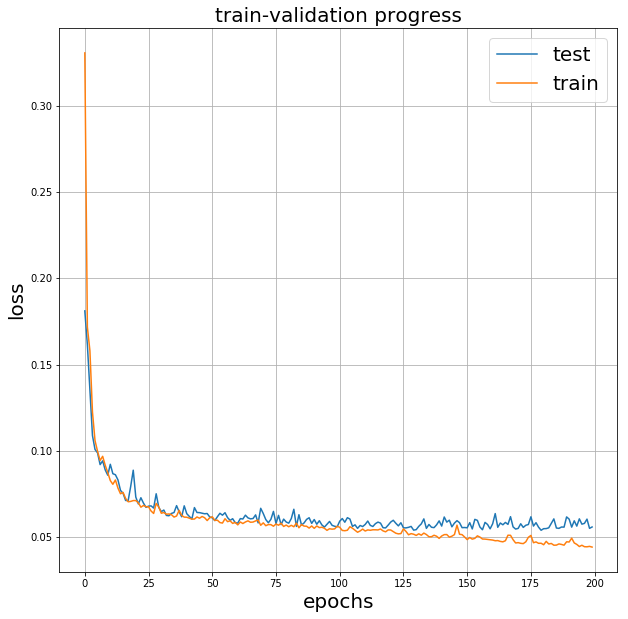

training completed!
weights loaded!
score_test: 0.05408
average dice: 0.90
------------------------------
average score for 5 folds is 0.0566033494784


In [8]:
n_folds=5
skf = ShuffleSplit(n_splits=n_folds, test_size=0.1, random_state=321)

# loop over folds
foldnm=0
scores_nfolds=[]

print ('wait ...')
for train_ind, test_ind in skf.split(X,Y):
    foldnm+=1    

    train_ind=list(np.sort(train_ind))
    test_ind=list(np.sort(test_ind))
    
    X_train,Y_train=X[train_ind],np.array(Y[train_ind],'uint8')
    X_test,Y_test=X[test_ind],np.array(Y[test_ind],'uint8')
    
    array_stats(X_train)
    array_stats(Y_train)
    array_stats(X_test)
    array_stats(Y_test)
    print ('-'*30)

    # exeriment name to record weights and scores
    experiment=netinfo+'_hw_'+str(h)+'by'+str(w)+'_initfilts_'+str(params_train['initial_channels'])
    print ('experiment:', experiment)

    weightfolder='./output/weights/'+experiment+'/fold'+str(foldnm)
    if  not os.path.exists(weightfolder):
        os.makedirs(weightfolder)
        print ('weights folder created')    
    
    # path to weights
    path2weights=weightfolder+"/weights.hdf5"
    path2model=weightfolder+"/model.hdf5"    
    
    # train test on fold #
    params_train['foldnm']=foldnm
    params_train['learning_rate']=initialLearningRate
    params_train['path2weights']=path2weights
    params_train['path2model']=path2model
    model=model_skip(params_train)
    #model.summary()    
    train_test_model(X_train,Y_train,X_test,Y_test,params_train)
    
    # loading best weights from training session
    if  os.path.exists(path2weights):
        model.load_weights(path2weights)
        print 'weights loaded!'
    else:
        raise IOError('weights does not exist!!!')
    
    score_test=model.evaluate(preprocess(X_test,norm_type),Y_test,verbose=0,batch_size=8)
    print ('score_test: %.5f' %(score_test))    
    Y_pred=model.predict(preprocess(X_test,norm_type))>0.5
    dicePerFold,_=calc_dice(Y_test,Y_pred)
    print('average dice: %.2f' %dicePerFold)
    print ('-' *30)
    # store scores for all folds
    scores_nfolds.append(score_test)

print ('average score for %s folds is %s' %(n_folds,np.mean(scores_nfolds)))    

### diaply predictions

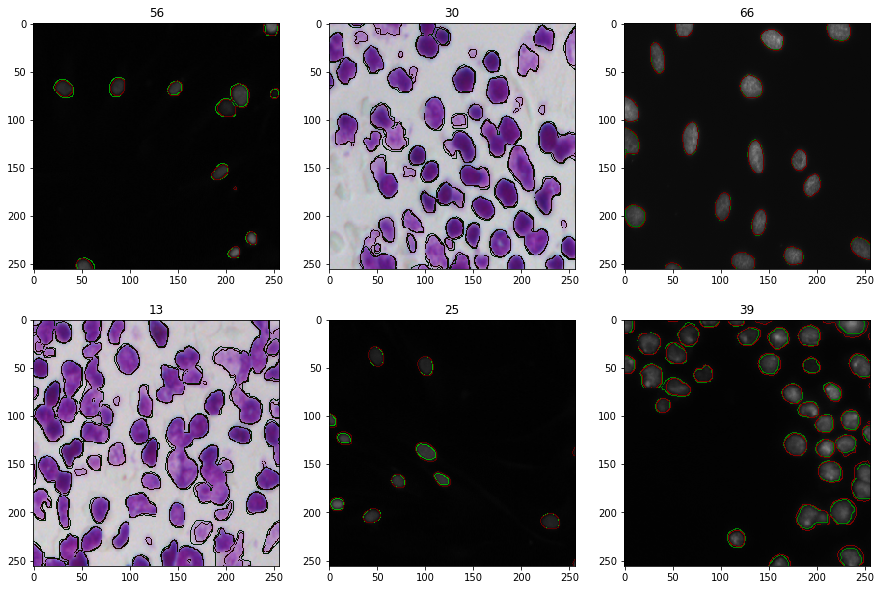

In [9]:
plt.figure(figsize=(15,10))
disp_img_2masks(X_test,Y_test,Y_pred,r=2,c=3)

### display after resizing

('array shape: ', (256, 320), dtype('float64'))
min: 0.0, max: 1.0, avg: 0.349, std:0.468
('array shape: ', (3, 256, 320), dtype('uint8'))
min: 16, max: 232, avg: 1.74e+02, std:46.9


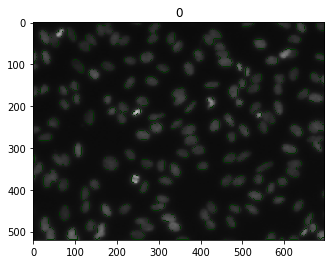

In [10]:
Y_testResized=resizeY(Y_pred,HW_train[test_ind])
X_testResized=resizeX(X_test,HW_train[test_ind])
array_stats(Y_testResized[0])
array_stats(X_testResized[0])

#disp_img_2masks(X_test,Y_test,Y_pred,r=2,c=3)
n1=np.random.randint(len(X_testResized))
disp_img_2masks(X_testResized[n1][np.newaxis],Y_testResized[n1][np.newaxis,np.newaxis],r=1,c=1)

## Predict on Leaderboard Data

loading ../data/trainTestH256W256.hdf5
('array shape: ', (65, 3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 53.4, std:74.8
('array shape: ', (65, 3), dtype('uint16'))
min: 3, max: 696, avg: 2.66e+02, std:2.28e+02


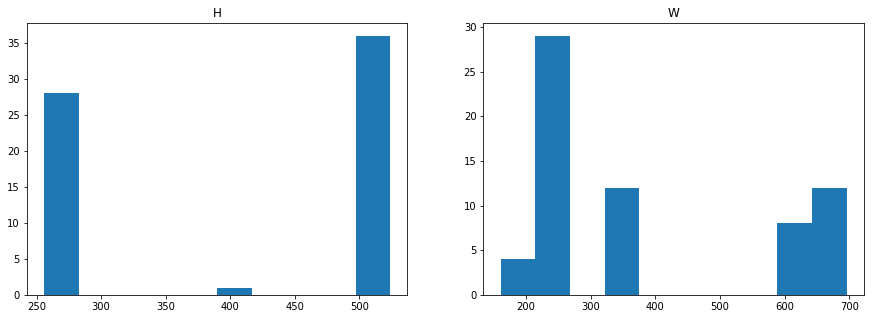

fold: 1
experiment: trainTest4_hw_256by256_initfilts_16
./output/weights/trainTest4_hw_256by256_initfilts_16/fold1/weights.hdf5 loaded!
('array shape: ', (65, 1, 256, 256), dtype('float32'))
min: 2.52201019925e-32, max: 1.0, avg: 0.157, std:0.326
--------------------------------------------------
fold: 2
experiment: trainTest4_hw_256by256_initfilts_16
./output/weights/trainTest4_hw_256by256_initfilts_16/fold2/weights.hdf5 loaded!
('array shape: ', (65, 1, 256, 256), dtype('float32'))
min: 1.04141503107e-16, max: 1.0, avg: 0.154, std:0.321
--------------------------------------------------
fold: 3
experiment: trainTest4_hw_256by256_initfilts_16
./output/weights/trainTest4_hw_256by256_initfilts_16/fold3/weights.hdf5 loaded!
('array shape: ', (65, 1, 256, 256), dtype('float32'))
min: 7.77151630507e-20, max: 1.0, avg: 0.147, std:0.321
--------------------------------------------------
fold: 4
experiment: trainTest4_hw_256by256_initfilts_16
./output/weights/trainTest4_hw_256by256_initfilts_

In [11]:
X_leader,_,HW_leader=loadData(path2h5,'leader')
array_stats(X_leader)
array_stats(HW_leader)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(HW_leader[:,0])
plt.title('H')
plt.subplot(1,2,2)
plt.hist(HW_leader[:,1])
plt.title('W')
plt.show()

n_folds=5
# prediction for nfolds
Y_leaderAllFolds=[]
for foldnm in range(1,n_folds+1):
    print('fold: %s' %foldnm)
    # load weights
    experiment=netinfo+'_hw_'+str(h)+'by'+str(w)+'_initfilts_'+str(params_train['initial_channels'])
    print ('experiment: %s' %experiment)
    weightfolder='./output/weights/'+experiment+'/fold'+str(foldnm)
    # path to weights
    path2weights=weightfolder+"/weights.hdf5"
    if  os.path.exists(path2weights):
        model.load_weights(path2weights)
        print ('%s loaded!' %path2weights)
    else:
        raise IOError ('weights does not exist!')

    # prediction
    Y_leader_perfold=model.predict(preprocess(X_leader.value,norm_type))
    array_stats(Y_leader_perfold)
    Y_leaderAllFolds.append(Y_leader_perfold)        
    print('-'*50)

# convert to array
Y_leader=np.hstack(Y_leaderAllFolds)
print ('ensemble shape:', Y_leader.shape)
Y_leader=np.mean(Y_leader,axis=1)[:,np.newaxis]
array_stats(Y_leader)

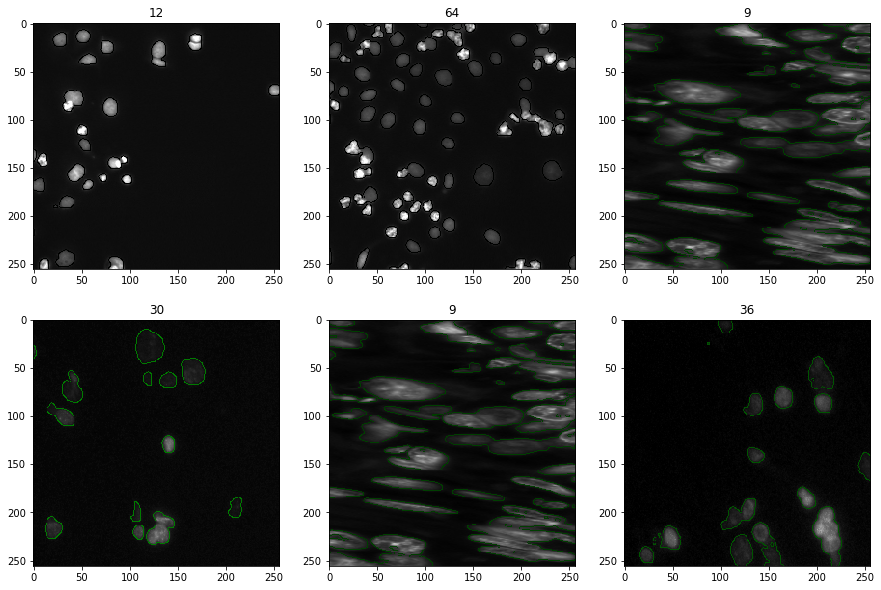

In [12]:
plt.figure(figsize=(15,10))
disp_img_2masks(X_leader,Y_leader>0.5,r=2,c=3)

### display after resizing 

('array shape: ', (256, 256), dtype('float64'))
min: 0.0, max: 1.0, avg: 0.0171, std:0.129
('array shape: ', (3, 256, 256), dtype('uint8'))
min: 1, max: 77, avg: 3.93, std:4.88
('array shape: ', (256, 256), dtype('float64'))
min: 0.0, max: 1.0, avg: 0.22, std:0.414
('array shape: ', (3, 256, 256), dtype('uint8'))
min: 0, max: 255, avg: 22.3, std:36.8
2 0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732


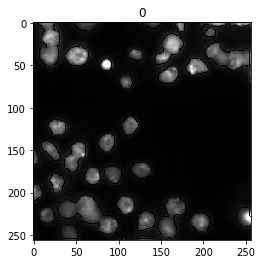

In [13]:
Y_leaderResized=resizeY(Y_leader>0.5,HW_leader)
X_leaderResized=resizeX(X_leader,HW_leader)
array_stats(Y_leaderResized[0])
array_stats(X_leaderResized[0])

#disp_img_2masks(X_test,Y_test,Y_pred,r=2,c=3)
n1=np.random.randint(len(X_leaderResized))
array_stats(Y_leaderResized[n1])
array_stats(X_leaderResized[n1])
print n1,test_ids[n1]
disp_img_2masks(X_leaderResized[n1][np.newaxis],Y_leaderResized[n1][np.newaxis,np.newaxis],r=1,c=1)

In [14]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)
        
        

In [15]:
array_stats(Y_leader)
Y_leaderResized=resizeY(Y_leader,HW_leader)
array_stats(Y_leaderResized[0])

new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(Y_leaderResized[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

('array shape: ', (65, 1, 256, 256), dtype('float32'))
min: 6.48877381947e-14, max: 1.0, avg: 0.152, std:0.317
('array shape: ', (256, 256), dtype('float64'))
min: 1.20464234143e-08, max: 0.999915122986, avg: 0.0176, std:0.124


In [16]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

now = datetime.datetime.now()
info=experiment
suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
submissionFolder='./output/submissions'
if not os.path.exists(submissionFolder):
    os.mkdir(submissionFolder)
    print(submissionFolder+ ' created!')
path2submission = os.path.join(submissionFolder, 'submission_' + suffix + '.csv')
print(path2submission)
sub.to_csv(path2submission, index=False)
sub.head()

./output/submissions/submission_trainTest4_hw_256by256_initfilts_16_2018-02-04-09-30.csv


,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,44852 2 45104 9 45359 11 45614 13 45869 14 461...
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50025 4 50278 10 50533 12 50788 14 51042 16 51...
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,10892 6 11146 9 11401 10 11656 12 11911 13 121...
3,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,31630 9 31884 13 32138 15 32393 17 32648 18 32...
4,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50842 4 51096 7 51350 10 51605 11 51860 12 521...
